In [1]:
# Third party
import importlib
import torch
import matplotlib.pyplot as plt

# User
import base.abstract
import base.mlp
import base.train
import base.encode
import base.pre_process
import base.viz
import model

importlib.reload(base.abstract)
importlib.reload(base.mlp)
importlib.reload(base.train)
importlib.reload(base.encode)
importlib.reload(base.pre_process)
importlib.reload(base.viz)
importlib.reload(base.norm)
importlib.reload(model)

from base.mlp import MLP, LinearLayer
from base.train import sgd
from base.encode import get_encoder_decoder
from base.pre_process import get_dataset
from base.viz import *
from base.norm import LayerNorm
from model import EmbMLP

In [2]:
encoder, decoder = get_encoder_decoder(training_data="../data/shakespear.txt", type='character')
# let's now encode the entire text dataset and store it into a torch.Tensor
with open("../data/shakespear.txt", 'r', encoding='utf-8') as f:
    text = f.read()
text_encoded = torch.tensor(encoder(text), dtype=torch.long)
unique_chars = sorted(list(set(text)))

In [3]:
token_length = 10
dataset =  get_dataset(text_encoded, token_length, context_window="fixed")
train_data, train_targets = dataset["train"]
validation_data, validation_targets = dataset["validation"]
len(train_data), len(validation_data)


(948085, 167309)

In [4]:
decoder(train_data[10].tolist()), train_data[10], train_targets[10]

('First Citi', tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47]), tensor(64))

In [12]:
g = torch.Generator().manual_seed(2147483647)

hp = {
    "init_learning_rate": .001,
    "converging_learning_rate": .01,
    "epochs": 100000,
    "epochs_log_interval": 10000,
    "dim_of_embedding": 32,
    "num_layer_1_nodes": 40,
    "num_layer_2_nodes": 40,
    "num_layer_3_nodes": 40,
    "num_layer_4_nodes": 40,
    "mini_batch_size": 32,
    "token_length": token_length
}

params = {
    "num_of_unique_chars": len(unique_chars)
}

l1 = LinearLayer(
    num_of_inputs=hp['token_length'] * hp['dim_of_embedding'],
    num_of_neurons=hp['num_layer_1_nodes'],
    normalizer=LayerNorm(hp['num_layer_1_nodes']),
    activation_func=torch.tanh,
    append_activation_layer=True,
    retain_activations=True,
    generator=g,
)

l2 = LinearLayer(
    num_of_inputs=hp['num_layer_1_nodes'],
    num_of_neurons=hp['num_layer_2_nodes'],
    normalizer=LayerNorm(hp['num_layer_2_nodes']),
    activation_func=torch.tanh,
    append_activation_layer=True,
    retain_activations=True,
    generator=g
)

l3 = LinearLayer(
    num_of_inputs=hp['num_layer_2_nodes'],
    num_of_neurons=hp['num_layer_3_nodes'],
    normalizer=LayerNorm(hp['num_layer_3_nodes']),
    activation_func=torch.tanh,
    append_activation_layer=True,
    retain_activations=True,
    generator=g
)

l4 = LinearLayer(
    num_of_inputs=hp['num_layer_3_nodes'],
    num_of_neurons=hp['num_layer_4_nodes'],
    normalizer=LayerNorm(hp['num_layer_4_nodes']),
    activation_func=torch.tanh,
    append_activation_layer=True,
    retain_activations=True,
    generator=g
)

l5 = LinearLayer(
    num_of_inputs=hp['num_layer_4_nodes'],
    num_of_neurons=len(unique_chars),
    generator=g
)

mlp = MLP([l1,l2,l3,l4,l5])
model = EmbMLP(hp,mlp,generator=g,**params)


In [13]:
loss_list = []
model.require_grad()
sgd(hp, model, train_data, train_targets, loss_list)

epoch: 0 / 100000, loss: 10.4088
epoch: 10000 / 100000, loss: 3.5507
epoch: 20000 / 100000, loss: 3.0582
epoch: 30000 / 100000, loss: 3.6167
epoch: 40000 / 100000, loss: 3.4186
epoch: 50000 / 100000, loss: 3.3441
epoch: 60000 / 100000, loss: 3.5085
epoch: 70000 / 100000, loss: 3.3389
epoch: 80000 / 100000, loss: 3.1927
epoch: 90000 / 100000, loss: 3.6661


In [5]:
# Compute negative log likelihood of the train/validation
model.disable_logging() # do not append layer diagnostics during the forward pass
print(f"train loss: {model.dataset_loss(train_data, train_targets)}")
print(f"validation loss: {model.dataset_loss(validation_data, validation_targets)}" )

train loss: 10.18357810583444
validation loss: 10.14110765095857


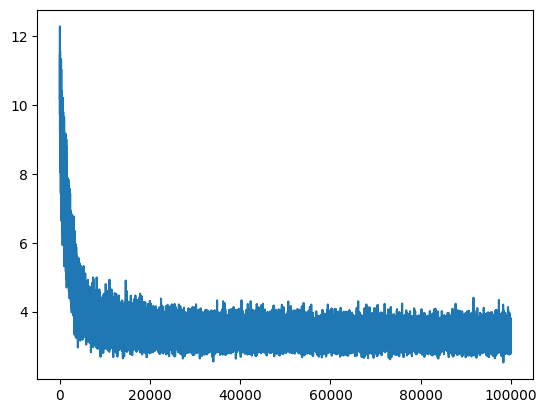

In [8]:
plt.plot(loss_list)

layer 0 (LinearLayer): mean -0.05, std 0.63, saturated: 3.36%
layer 1 (LinearLayer): mean -0.01, std 0.68, saturated: 5.70%
layer 2 (LinearLayer): mean -0.02, std 0.71, saturated: 8.98%
layer 3 (LinearLayer): mean +0.00, std 0.53, saturated: 2.42%


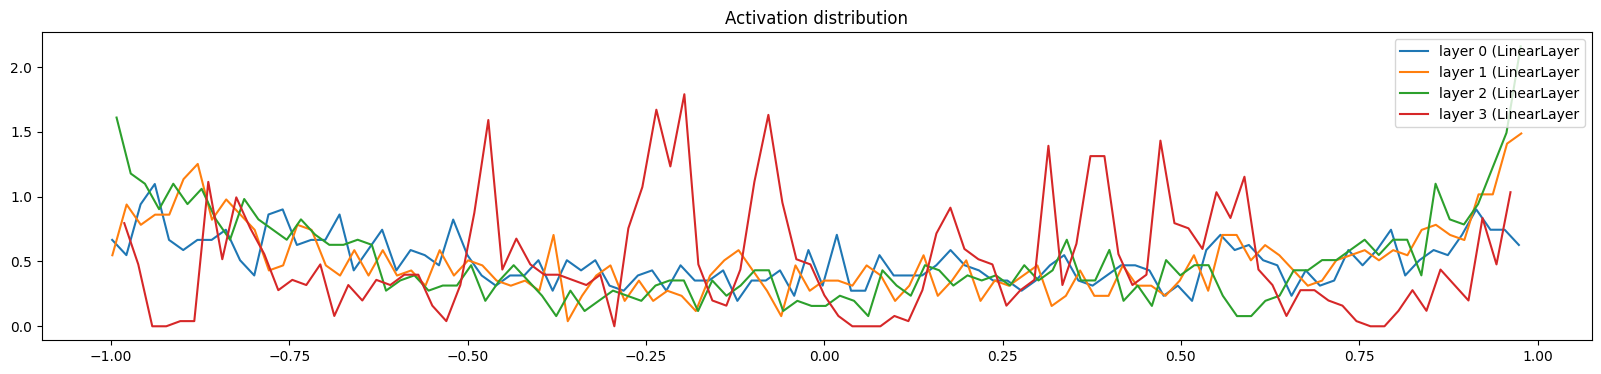

In [14]:
plot_activation_distributions([l1,l2,l3,l4])

layer 0 (LinearLayer): mean -0.000064, std 2.200788e-03
layer 1 (LinearLayer): mean +0.000049, std 3.387529e-03
layer 2 (LinearLayer): mean +0.000453, std 7.209371e-03
layer 3 (LinearLayer): mean +0.000938, std 3.086075e-02


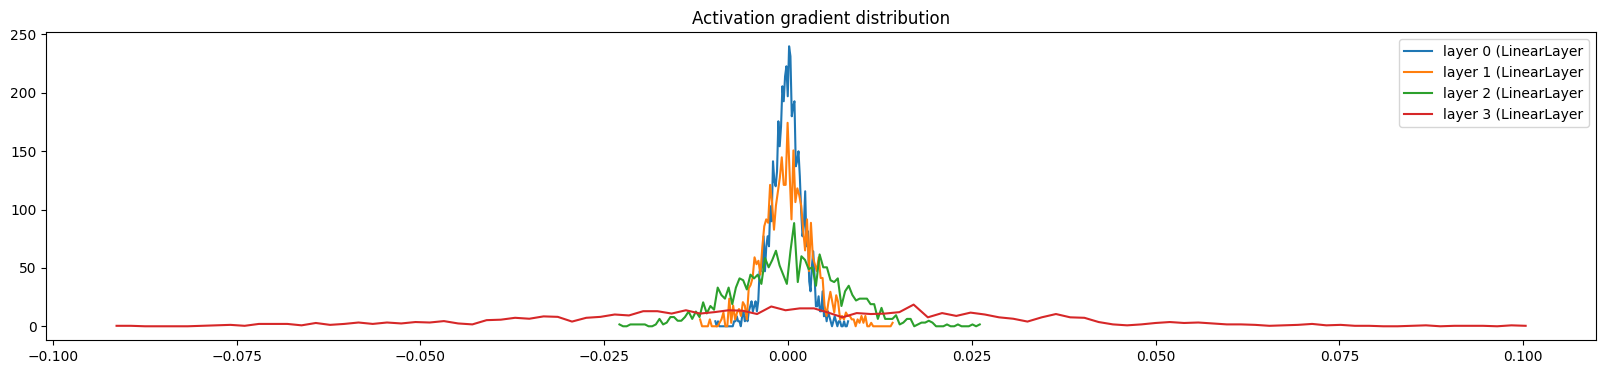

In [15]:
plot_activation_grad_distributions([l1,l2,l3,l4])

layer: LinearLayer | weight  (320, 40) | mean -0.000000 | std 4.041995e-04 | grad:data ratio 4.027617e-04
layer: LinearLayer | weight   (40, 40) | mean -0.000000 | std 1.358721e-03 | grad:data ratio 1.372349e-03
layer: LinearLayer | weight   (40, 40) | mean -0.000000 | std 2.271740e-03 | grad:data ratio 2.247857e-03
layer: LinearLayer | weight   (40, 40) | mean -0.000000 | std 4.876165e-03 | grad:data ratio 4.784239e-03
layer: LinearLayer | weight   (40, 65) | mean +0.000000 | std 1.107999e-02 | grad:data ratio 1.122913e-02


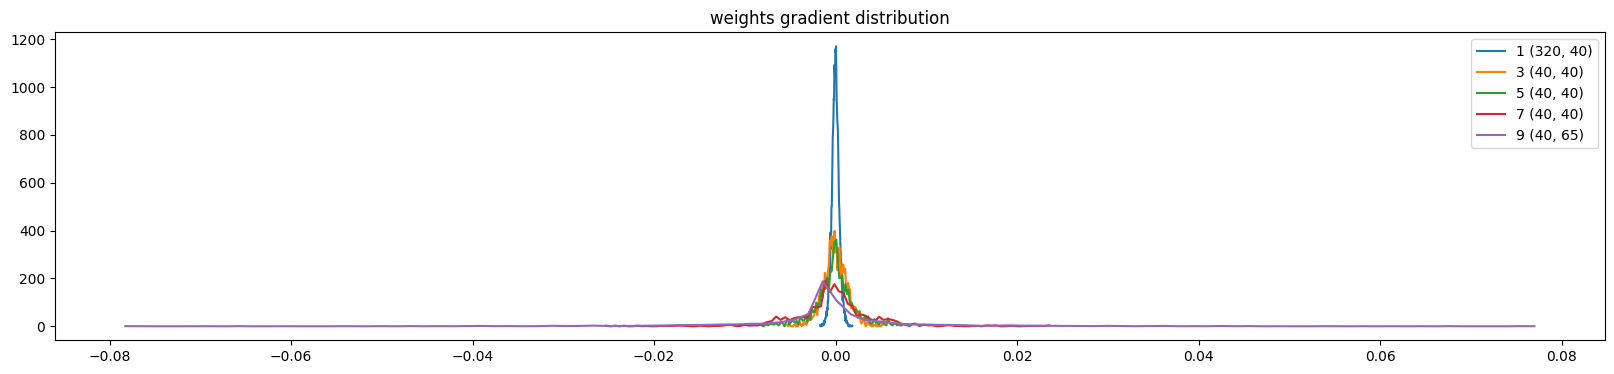

In [16]:
plot_parameters_grads(model.params())

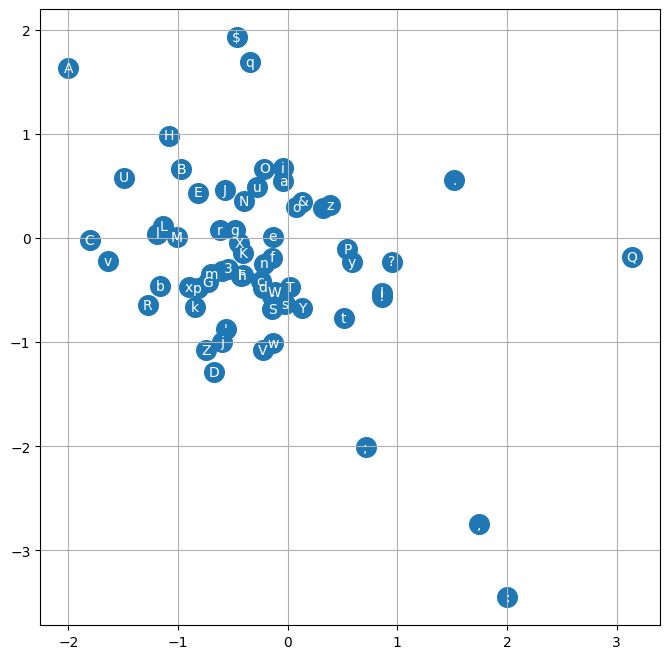

In [39]:
plot_2d_char_embedding(unique_chars, model.embedding)


In [42]:
print(decoder(model.generate(1000)))

LEHINLUNfhl:
Cely.

KISARY Bis:
Fon eqpefaen, thete nante wary
thos mineles? Bapyd: nout am os btherbens!
Ong ay haRetthill doth kice golneprafe.

Thend.

IS:
Wheme cou the vobd then as, lr hanghtreeur ise the s-I-Sirte duvegenghf the ogon wos?
Ot
AMTURIBACISIN:
Wha.
CARIENNINEIUECISIN:
Whille trourchinls rewelb-Gat wot hly ha as tay, hes me twer, each borlltow koterssor ind, tik hor,
Dhunuuve cor bos hevly so throt sarr: sovenpe be hafand wos poindas, qloun thedoe I meyd pimaau libi sorir Case I rance a aresor rot timiw' theruxtaaf thor tetos, horas lome fydhha; tom; pey wher Iutf lat dy osr gas'st ot throe chere,
Thod3e, afet me tha becar bawlord thou thar,,
Thilnlniw as, thet chatorortot hot yor thir tyd'coy Hie I Mamly
Whonlir whem had pird.
Oy fount thet fly id?

LONURTUTCHAR:
Meme poveunet'd bokecoamt whenst Ely prurass Toslen: i nlecas leIiras,huti. hhe adronghe ocon, bory lhod leesll'are hus ireebe oum
Ny,
CERIOHY:
Mim beme gopr shle ond ond sot th ay ores,
Tha bifhy,
Bakay, sh